Estimated initial time offset: -0.09299999999999997 seconds


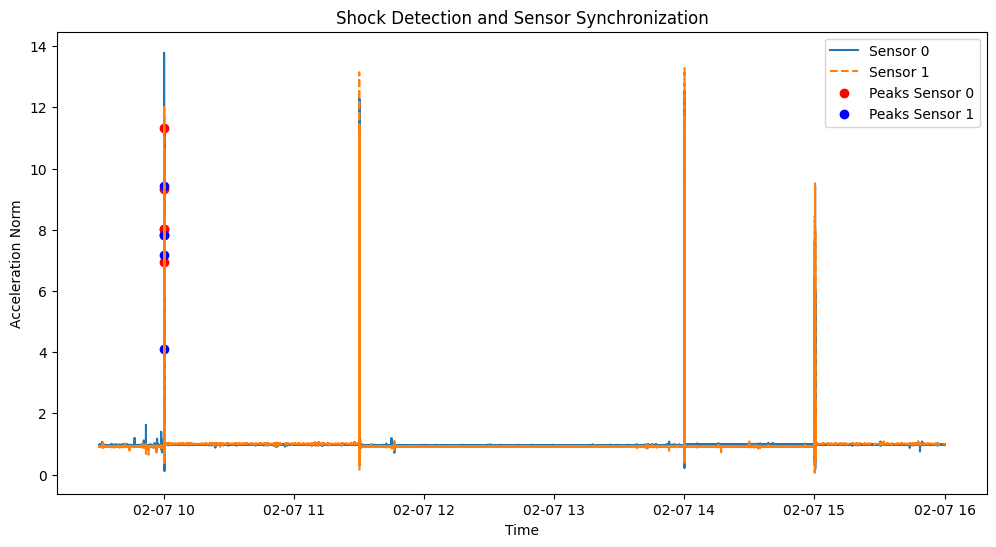

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Load CSV files
df = pd.read_csv('../data/0.csv')
df1 = pd.read_csv('../data/1.csv')

# Rename columns (if necessary)
df.columns = ['timestamp', 'X', 'Y', 'Z']
df1.columns = ['timestamp', 'X', 'Y', 'Z']

# Convert the timestamp column to datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'])
df1['timestamp'] = pd.to_datetime(df1['timestamp'])

# Compute the acceleration norm (magnitude)
df['acc_norm'] = np.sqrt(df['X']**2 + df['Y']**2 + df['Z']**2)
df1['acc_norm'] = np.sqrt(df1['X']**2 + df1['Y']**2 + df1['Z']**2)

# Detect movement shocks (peaks in acceleration norm)
peaks_df, _ = find_peaks(df['acc_norm'], height=4)  # Adjust the threshold based on the dataset
peaks_df1, _ = find_peaks(df1['acc_norm'], height=4)  

# Retrieve timestamps of detected peaks
timestamps_df = df.loc[peaks_df, 'timestamp'].values
timestamps_df1 = df1.loc[peaks_df1, 'timestamp'].values

# Check if peaks were detected in both accelerometer datasets
if len(timestamps_df) == 0 or len(timestamps_df1) == 0:
    print("Error: No peaks detected in one of the files.")
    exit()

# Compare the first N peaks to estimate the time offset
N = min(len(timestamps_df), len(timestamps_df1), 5)  # Use up to 5 peaks for alignment

# Compute the time differences between corresponding peaks
time_offsets = [pd.Timedelta(timestamps_df1[i] - timestamps_df[i]).total_seconds() for i in range(N)]

# Take the median of the differences to avoid outliers
initial_offset = np.median(time_offsets)

print(f"Estimated initial time offset: {initial_offset} seconds")

# Apply the initial time correction to df1
df1['timestamp'] = df1['timestamp'] - pd.to_timedelta(initial_offset, unit='s')

# Plot the results to visually check alignment
plt.figure(figsize=(12, 6))
plt.plot(df['timestamp'], df['acc_norm'], label="Sensor 0")
plt.plot(df1['timestamp'], df1['acc_norm'], label="Sensor 1", linestyle="dashed")
plt.scatter(timestamps_df[:N], df.loc[peaks_df[:N], 'acc_norm'], color='red', label="Peaks Sensor 0")
plt.scatter(timestamps_df1[:N], df1.loc[peaks_df1[:N], 'acc_norm'], color='blue', label="Peaks Sensor 1")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Acceleration Norm")
plt.title("Shock Detection and Sensor Synchronization")
plt.show()


In [23]:
# Apply the estimated time offset to df1
df1['timestamp'] = df1['timestamp'] - pd.to_timedelta(initial_offset, unit='s')

# Check the time ranges before reindexing
print(f"Time range df: {df['timestamp'].min()} -> {df['timestamp'].max()}")
print(f"Time range df1: {df1['timestamp'].min()} -> {df1['timestamp'].max()}")

# Interpolation and filling missing values
df1_interp = df1.set_index('timestamp').reindex(df['timestamp']).interpolate().bfill().ffill().reset_index()

# Rename columns to avoid conflicts
df.rename(columns={'X': 'X_0', 'Y': 'Y_0', 'Z': 'Z_0'}, inplace=True)
df1_interp.rename(columns={'X': 'X_1', 'Y': 'Y_1', 'Z': 'Z_1'}, inplace=True)

# Merge the two DataFrames on timestamps
df_sync = pd.merge(df, df1_interp, on='timestamp', how='inner')

# Check if any NaN values remain after interpolation
print("Number of NaN values remaining after interpolation:")
print(df_sync.isna().sum())

# Final verification
print(df_sync.head())

# Save the synchronized data to a CSV file for future analysis
#df_sync.to_csv('../data/Synchronisation/synchronized_data.csv', index=False)


Time range df: 2025-02-07 09:30:05.699000 -> 2025-02-07 16:00:02.620000
Time range df1: 2025-02-07 09:30:06.305000 -> 2025-02-07 16:00:03.266000
Number of NaN values remaining after interpolation:
timestamp     0
X_0           0
Y_0           0
Z_0           0
acc_norm_x    0
X_1           0
Y_1           0
Z_1           0
acc_norm_y    0
dtype: int64
                timestamp      X_0       Y_0       Z_0  acc_norm_x       X_1  \
0 2025-02-07 09:30:05.699 -0.09375 -0.015625  0.906250    0.911220 -0.015625   
1 2025-02-07 09:30:05.720 -0.09375 -0.031250  0.953125    0.958234 -0.015625   
2 2025-02-07 09:30:05.739 -0.09375 -0.015625  0.953125    0.957852 -0.015625   
3 2025-02-07 09:30:05.760 -0.09375 -0.015625  0.953125    0.957852 -0.015625   
4 2025-02-07 09:30:05.779 -0.09375 -0.015625  0.953125    0.957852 -0.015625   

       Y_1       Z_1  acc_norm_y  
0 -0.03125  0.921875    0.922537  
1 -0.03125  0.921875    0.922537  
2 -0.03125  0.921875    0.922537  
3 -0.03125  0.921875    0

In [24]:
# Compute the time differences between consecutive samples
df_sync['delta_t_0'] = df_sync['timestamp'].diff().dt.total_seconds()
df_sync['delta_t_1'] = df_sync['timestamp'].diff().dt.total_seconds()  # Same time reference after synchronization

# Compute the average sampling frequency
freq_0 = 1 / df_sync['delta_t_0'].mean()
freq_1 = 1 / df_sync['delta_t_1'].mean()

print(f"Sampling frequency of sensor 0: {freq_0:.4f} Hz")
print(f"Sampling frequency of sensor 1: {freq_1:.4f} Hz")


Sampling frequency of sensor 0: 50.9400 Hz
Sampling frequency of sensor 1: 50.9400 Hz
